这个是查看均线多头后经过多长时间以及涨跌的比率

In [2]:
import pandas as pd
import numpy as np
import talib
# import tqdm
from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 8.0) # 单位是inches

# 导入数据

In [3]:
data = pd.read_csv("../../数据获取/聚宽数据/最新数据.csv")
data=data.set_index(['Unnamed: 0', 'Unnamed: 1'])
print('共导入{}行数据,股票个数：{},平均每个股票的的数据量:{}'.format(
    len(data),
    len(data.index.levels[0]),
    len(data)//len(data.index.levels[0])
))
data.head()

共导入3704160行数据,股票个数：4136,平均每个股票的的数据量:895


date   open   high    low  close
Unnamed: 0  Unnamed: 1                                        
000001.XSHE 0           2018-04-18  10.89  11.04  10.72  10.93
            1           2018-04-19  10.95  11.11  10.86  10.90
            2           2018-04-20  10.94  11.01  10.65  10.79
            3           2018-04-23  10.74  11.04  10.70  11.00
            4           2018-04-24  11.06  11.35  11.01  11.28

# 统计数据

In [4]:
# 先一个图片的
data_one = data.loc[data.index.levels[0][0]].copy() # 这个是每一个股票的数据

# 这里首先添加均线，
for ma_day in [5,10,20,30,60,120]:
    # 插入多条均线
    data_one.insert(
        loc=len(data_one.columns),
        column='ma{}'.format(ma_day),
        value=talib.MA(data_one['close'], timeperiod=ma_day)
    )
# 然后这里是比较了。
data_one.insert(
    loc=len(data_one.columns),
    column='均线多头',
    value=(data_one['ma5'] > data_one['ma10'] ) & (data_one['ma10'] > data_one['ma20'] )& (data_one['ma20'] > data_one['ma30']) 
)
# 然后是遍历了
data_one[data_one['均线多头']]
# 这里寻找这一支股票下跌的时候是什么样子


,date,open,high,low,close,ma5,ma10,ma20,ma30,ma60,ma120,均线多头
Unnamed: 1,,,,,,,,,,,,
90,2018-08-27,9.67,10.07,9.62,10.07,9.332,8.949,8.8740,8.855000,8.922167,NaN,True
91,2018-08-28,9.98,10.07,9.88,9.93,9.536,9.073,8.9160,8.905333,8.925000,NaN,True
92,2018-08-29,9.89,9.97,9.80,9.91,9.724,9.216,8.9700,8.955667,8.927667,NaN,True
93,2018-08-30,9.91,9.99,9.73,9.77,9.872,9.346,9.0270,9.000333,8.929833,NaN,True
94,2018-08-31,9.78,9.96,9.75,9.78,9.892,9.474,9.0860,9.033333,8.928500,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...
890,2021-12-14,18.16,18.17,17.52,17.58,18.280,18.084,17.9490,17.938000,18.505667,19.294167,True
967,2022-04-12,16.05,16.26,15.66,15.92,16.208,15.691,15.1745,15.140667,15.887500,16.988417,True
968,2022-04-13,15.89,16.08,15.72,15.80,16.090,15.786,15.2400,15.142333,15.864333,16.956250,True


In [5]:
lst_duotou_days = [] # 这个是均线多头每次持续的日期
lst_duotou_range = [] # 这个是每一次的幅度
lst_duotou_range2 = [] # 这个是开盘价的幅度
with tqdm(range(len(data.index.levels[0]))) as bar:
    for id in data.index.levels[0]:
        data_one = data.loc[id].copy() # 这个是每一个股票的数据
        # 上边的格式比较固定，遍历每一个股票,然后下边开始统计
        # 这里首先添加均线，
        for ma_day in [5,10,20,30,60,120]:
            # 插入多条均线
            data_one.insert(
                loc=len(data_one.columns),
                column='ma{}'.format(ma_day),
                value=talib.MA(data_one['close'], timeperiod=ma_day)
            )
        # 然后这里是比较了。
        data_one.insert(
            loc=len(data_one.columns),
            column='均线多头',
            value=(data_one['ma5'] > data_one['ma10'] ) & (data_one['ma10'] > data_one['ma20'] )& (data_one['ma20'] > data_one['ma30']) 
        )
        # 下边开始统计
        j = 0
        while j < len(data_one):
            # 遍历每一个的数据
            if  data_one.loc[j, '均线多头']:
                # 碰到均线开头的第一天
                if j + 1 < len(data_one):
                    # 如果不是最后一天
                    j = j + 1 # 下一天
                    j_start = j #  保留起始的
                    while j < len(data_one) and data_one.loc[j, '均线多头'] :
                        j = j + 1 # 寻找结束
                    if j >= len(data_one):
                        # 是否是最后一天,需要回退。
                        j = j - 1
                    # 这里要记录幅度了
                    lst_duotou_range.append(
                        (data_one.loc[j, 'close']- data_one.loc[j_start, 'close'])/ data_one.loc[j_start, 'close']*100
                    ) # 幅度
                    lst_duotou_range2.append(
                        (data_one.loc[j, 'open']- data_one.loc[j_start, 'open'])/ data_one.loc[j_start, 'open']*100
                    ) # 幅度
                    lst_duotou_days.append(j - j_start + 1) # 天数
                    pass
                else:
                    j = j + 1
            else:
                j = j + 1
            # 进度条
        bar.update(1)
        

  0%|          | 0/4136 [00:00<?, ?it/s]

# 查看结果

## 天数的统计

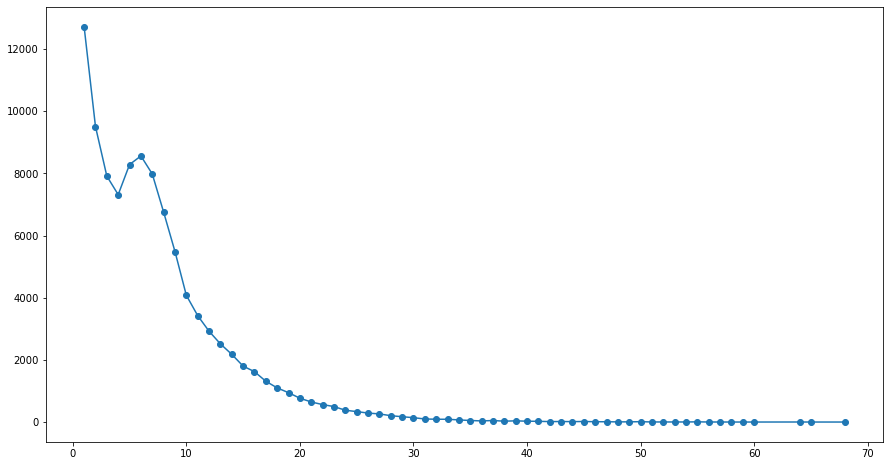

In [6]:
lst_duotou_days_set = list(set(lst_duotou_days)) # 首先不重复的
lst_duotou_days_set.sort() # 排序
lst_duotou_days_set_value = [lst_duotou_days.count(i) for i in lst_duotou_days_set] # 统计个数
# 如下是画图
plt.scatter(lst_duotou_days_set, lst_duotou_days_set_value) # 散点图
plt.plot(lst_duotou_days_set, lst_duotou_days_set_value) # 折线图

这个看起来，只有一两个的情况很多，但是其他的也不是太逊色啊。

In [7]:
print(lst_duotou_days_set[:10])
print(lst_duotou_days_set_value[:10])
lst_duotou_days_set_value_sum = sum(lst_duotou_days_set_value)
print(['{:.2f}%'.format(i*100.0/lst_duotou_days_set_value_sum) for i in lst_duotou_days_set_value][:10])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[12717, 9505, 7911, 7315, 8282, 8560, 7980, 6754, 5486, 4077]
['12.54%', '9.37%', '7.80%', '7.21%', '8.17%', '8.44%', '7.87%', '6.66%', '5.41%', '4.02%']


看起来，均线多头，只有不到1/10的概率是第一次显示后就不持续的。

## 上涨幅度

In [8]:
print('收盘价的幅度')
lst_duotou_range_up = [i for i in lst_duotou_range if i >0]
lst_duotou_range_down = [i for i in lst_duotou_range if i < 0]
lst_duotou_range_up.sort()
lst_duotou_range_down.sort()
lst_duotou_range_count = len(lst_duotou_range)
print('上涨的概率:{:.2f}%'.format(len(lst_duotou_range_up)*100.0/len(lst_duotou_range)))
print('上涨的平均:{:.2f}%,中值:{}'.format(sum(lst_duotou_range_up)/len(lst_duotou_range_up), lst_duotou_range_up[len(lst_duotou_range_up)//2]))
print('下跌的平均:{:.2f}%,中值:{}'.format(sum(lst_duotou_range_down)/len(lst_duotou_range_down), lst_duotou_range_down[len(lst_duotou_range_down)//2]))

收盘价的幅度
上涨的概率:29.87%
上涨的平均:8.53%,中值:3.69978858350951
下跌的平均:-4.64%,中值:-3.626220362622048


In [9]:
print('开盘价的幅度')
lst_duotou_range_up2 = [i for i in lst_duotou_range2 if i >0]
lst_duotou_range_down2 = [i for i in lst_duotou_range2 if i < 0]
lst_duotou_range_0 = [i for i in lst_duotou_range2 if i == 0]
lst_duotou_range_up2.sort()
lst_duotou_range_down2.sort()
lst_duotou_range_count2 = len(lst_duotou_range2)
print('上涨的概率:{:.2f}%, 不涨不跌的概率:{:.2f}%,下跌的概率:{:.2f}%'.format(
    len(lst_duotou_range_up2)*100.0/len(lst_duotou_range2),
    len(lst_duotou_range_0)*100.0/len(lst_duotou_range2),
    len(lst_duotou_range_down2)*100.0/len(lst_duotou_range2)
))
print('上涨的平均:{:.2f}%,中值:{:.2f}, 最大:{:.2f}%,'.format(
    sum(lst_duotou_range_up2)/len(lst_duotou_range_up2), 
    lst_duotou_range_up2[len(lst_duotou_range_up2)//2],
    max(lst_duotou_range_up2)
))
print('下跌的平均:{:.2f}%,中值:{:.2f},最小:{:.2f}%'.format(
    sum(lst_duotou_range_down2)/len(lst_duotou_range_down2), 
    lst_duotou_range_down2[len(lst_duotou_range_down2)//2],
    min(lst_duotou_range_down2)
))

开盘价的幅度
上涨的概率:34.36%, 不涨不跌的概率:13.70%,下跌的概率:51.94%
上涨的平均:8.67%,中值:3.87, 最大:398.93%,
下跌的平均:-4.12%,中值:-3.08,最小:-39.25%


## 图形

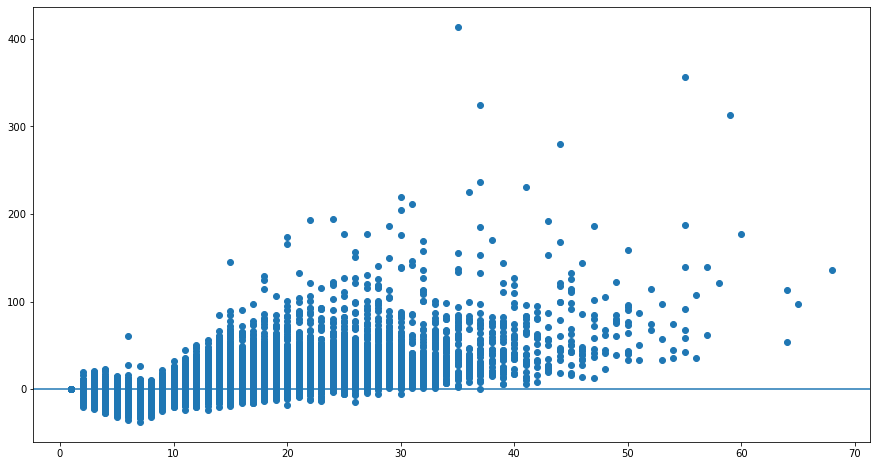

In [10]:
plt.scatter(lst_duotou_days, lst_duotou_range)
plt.axhline(0)